# Best Speech Classifier

In the last notebook [Speech-Classifier-02.ipynb](Speech-Classifier-02.ipynb), we compared classifiers that are optimized for the `profit_score` function. Here we would like to serialze the model so that it's ready for combining decision.

## Load Data

Load data based on best possible combination from last document.

In [13]:
# load data b
import pandas as pd

feature_column = pd.read_csv("../Data/speech_data/indixes_speech.csv")['RForSVM'][1:]
train_data = pd.read_csv("../Data/speech_data/speech_train_set.csv")
val_data = pd.read_csv("../Data/speech_data/speech_validation_set.csv")
test_data = pd.read_csv("../Data/speech_data/speech_test_set.csv")

### Undersample 

Shuffle and undersample

In [ ]:
# Shuffle
train_data = train_data.sample(frac=1, random_state=0)
# Undersampling
non_speech = train_data[train_data['class'] == 0]
speech = train_data[train_data['class'] == 1][:len(train_data[train_data['class'] == 0])]
dataset_train = speech.append(non_speech, ignore_index=True).sample(frac=1, random_state=0)

### Split data

Split into train, validatin, test.

In [ ]:
X_train, y_train = train_data[feature_column], train_data['class']
X_val, y_val = val_data[feature_column], val_data['class']
X_test, y_test = test_data[feature_column], test_data['class']

## Training

Fit the model and evaluate other metrics

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix
import handsomUtility

classifier = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                                           max_depth=1000, max_features='auto', max_leaf_nodes=None,
                                           min_impurity_decrease=0.0, min_impurity_split=None,
                                           min_samples_leaf=2, min_samples_split=6,
                                           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                                           oob_score=False, random_state=0, verbose=0, warm_start=False)

classifier.fit(X_train, y_train)
y_pred = handsomUtility.post_processing(classifier.predict(X_val.values))

Confusion Matrix: [0.52477931 0.01340134 0.02883548 0.43298387]
Accuracy: 0.9577631801840802
Actual Profit (after learning): 29560.200000015247


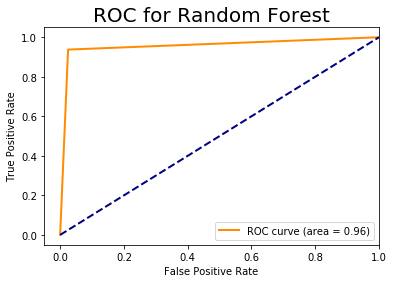

,accuracy,AUC,Actual Profit,Maximum Profit,TPR,FPR,FNR,TNR
Random Forest,0.957763,0.95633,29560.2,34156.2,0.524779,0.0134013,0.0288355,0.432984


In [46]:
accuracy = accuracy_score(y_val, y_pred)
cm = confusion_matrix(y_val, y_pred).ravel()/len(y_pred)
print("Confusion Matrix: {}".format(cm))
print("Accuracy: {}".format(accuracy_score(y_val, y_pred)))
print("Actual Profit (after learning): {}".format(handsomUtility.profit_score(y_val, y_pred)))
auc = handsomUtility.plotROC(y_val, y_pred, "Random Forest")
results = {'Accuracy': accuracy, 'AUC': auc, 'Actual Profit': handsomUtility.profit_score(y_val, y_pred), 'Maximum Profit': handsomUtility.profit_score(y_pred, y_pred), 'TPR':cm[0], 'FPR':cm[1], 'FNR':cm[2], 'TNR':cm[3]}
pd.DataFrame.from_dict(results, orient="index", columns=['Random Forest']).T.style.set_caption("Random Forest (RForSVM)")

## Serialization

Serialize the classifier so that we keep the weights.

In [49]:
import pickle
with open('../SpeechClassifier/best-speech-classifier.pkl', 'wb') as dump_file:
    pickle.dump()
    pickle.dump(classifier, dump_file) 

To load, use

In [51]:
import pickle
# load it again
with open('../SpeechClassifier/best-speech-classifier.pkl', 'rb') as dump_file:
    classifier_2 = pickle.load(dump_file) 

In [69]:
y_pred_2 = handsomUtility.post_processing(classifier_2.predict(X_val.values))
print(np.vstack((y_pred, y_pred_2)).T)

[[1. 1.]
 [1. 1.]
 [1. 1.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]
